<a href="https://colab.research.google.com/github/NinaNusb/Multilingual_NLP/blob/main/Lab1_One_model_to_rule_them_all%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One model to rule them all?







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install polyglot
!pip install sentencepiece
! pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import kenlm
print(dir(kenlm))

['ARPALoadComplain', 'Config', 'FullScoreReturn', 'LanguageModel', 'LoadMethod', 'Model', 'State', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'os']


In [ ]:
!git clone https://github.com/kpu/kenlm.git
%cd kenlm
!python setup.py develop
!mkdir -p build
%cd build
!cmake ..
!make -j 4

Cloning into 'kenlm'...
remote: Enumerating objects: 14161, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 14161 (delta 162), reused 406 (delta 131), pack-reused 13687
Receiving objects: 100% (14161/14161), 5.91 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (8042/8042), done.
/content/kenlm/build/kenlm
Will build with KenLM max_order set to 6
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  

In [ ]:
import tensorflow_datasets as tfds
from itertools import islice
import polyglot
from polyglot.text import Text, Word
import os
import kenlm
import logging
import subprocess
import matplotlib.pyplot as plt
import sentencepiece as spm
import seaborn as sns
import pandas as pd
import statistics

## Generating the corpora

In [ ]:
# first extract sentences from articles and tokenize them
ignore = ["_NEWLINE_", "\n_START_SECTION_\n", "\n_START_PARAGRAPH_\n", "_START_ARTICLE_"]

# sentences = [Text(sentence) if not sentence.startswith("_") else "" for sentence in text for text in sample]
# sentences2 = [(Text(sentence)).sentences if sentence not in ignore else "" for sentence in sample]

In [ ]:
# List of ISO 639-1 language codes available in the wiki40b corpus
lang_codes = ["ar", "bg", "ca", "cs", "da", "de", "el", "en", "es", "et", "fa", "fi", "fr", "he", "hi", "hr", "hu", "id", "it", "ja", "ko", "lt", "lv", "ms", "nl", "no", "pl", "pt", "ro", "ru", "sk", "sl", "sr", "sv", "th", "tl", "tr", "uk", "vi", "zh-cn", "zh-tw"]
all_data = pd.DataFrame({"languages": lang_codes})

In [ ]:
logging.getLogger('polyglot.detect.base').setLevel(logging.ERROR)

def tokenize_sentences_polyglot(text):
    sentences = Text(text).sentences
    return [str(sentence) for sentence in sentences]

def tokenize_sentences_sentencePiece(text):
    sp = spm.SentencePieceProcessor()
    # Split text into sentences (customize as needed)
    sentences = text.split('.')
    tokenized_sentences = [
        # Tokenize the sentence
        ' '.join(sp.encode(sentence, out_type=str)) for sentence in sentences]
    return tokenized_sentences

def tokenize_words_sentencePiece(model_file, lang, text):
    sp = spm.SentencePieceProcessor(model_file + lang + ".model")
    tokens = sp.encode(text, out_type=str)
    return tokens

# Dictionary to map tokenizer names to functions
tokenization_functions = {
    "polyglot": tokenize_sentences_polyglot,
    "sentencepiece": tokenize_sentences_sentencePiece,
}

In [ ]:
def get_unique_sentences(lang, nb_articles, tokenizer, split):
  # Get the tokenization function based on the tokenizer argument
  tokenize_sentences = tokenization_functions.get(tokenizer)
  if tokenize_sentences is None:
     raise ValueError("Invalid tokenizer")
  # Load the dataset for the current language with the appropriate split
  ds = tfds.load(f"wiki40b/{lang}", split=split, data_dir="gs://tfds-data/datasets")
  # Sample a subset of articles (adjust the number as needed)
  sampled_articles = [ex["text"].numpy().decode("utf-8") for ex in islice(ds.shuffle(buffer_size=10_000), nb_articles)]
   # Tokenize sentences using Polyglot and remove duplicates
  unique_sentences = list(set(sentence for article in sampled_articles for sentence in tokenize_sentences(article)))
  # Ensure you have enough unique sentences for train and test sets
  return unique_sentences

In [ ]:
def get_train_test_sets(lang, unique_sentences, train_size, test_size):
  # Split the sentences into train and test sets
  train_set = unique_sentences[:train_size]
  test_set = unique_sentences[train_size:train_size+test_size]
  train_sets[lang] = train_set
  test_sets[lang] = test_set
  return train_sets, test_sets

For each languages of the corpus extract a train set of 40,000 sentences and a test set of 3,000 sentences. Sentences must be unique (i.e. if there are several occurrences of an identical sentence, they must all be removed but one). Using polyglot tokenize all datasets into words. Save each dataset into a separate text file (one sentence per line) using consistent names to be able to automate the LM estimation.

In [ ]:
train_size = 40_000
test_size = 3_000
nb_articles = 10_000

train_sets = {}
test_sets = {}

for lang in lang_codes:
    unique_sentences = get_unique_sentences(lang, nb_articles, tokenizer="polyglot", split="test")
    if len(unique_sentences) >= (train_size + test_size):
        train_sets, test_sets = get_train_test_sets(lang, unique_sentences, train_size, test_size)
        print(f"Complete sample for {lang}")
    else:
        # Not enough unique sentences for both sets, switch to "train" split
        unique_sentences = get_unique_sentences(lang, nb_articles, tokenizer="polyglot", split="train")

        # Check if there are enough unique sentences for both train and test sets
        if len(unique_sentences) >= (train_size + test_size):
            train_sets, test_sets = get_train_test_sets(lang, unique_sentences, train_size, test_size)
            print(f"Complete sample for {lang} (using 'train' split)")
        else:
            available_unique_sentences = len(unique_sentences)
            print(f"Available unique sentences for {lang}: {available_unique_sentences}")

Complete sample for ar
Complete sample for bg
Complete sample for ca
Complete sample for cs
Complete sample for da
Complete sample for de
Complete sample for el
Complete sample for en
Complete sample for es
Complete sample for et
Complete sample for fa
Complete sample for fi
Complete sample for fr
Complete sample for he
Complete sample for hi
Complete sample for hr
Complete sample for hu
Complete sample for id
Complete sample for it
Complete sample for ja
Complete sample for ko
Complete sample for lt
Complete sample for lv (using 'train' split)
Complete sample for ms
Complete sample for nl
Complete sample for no
Complete sample for pl
Complete sample for pt
Complete sample for ro
Complete sample for ru
Complete sample for sk
Complete sample for sl
Complete sample for sr
Complete sample for sv
Complete sample for th (using 'train' split)
Complete sample for tl (using 'train' split)
Complete sample for tr
Complete sample for uk
Complete sample for vi
Complete sample for zh-cn
Complete sa

In [ ]:
print(len(lang_codes))
print(len(train_sets))
print(len(test_sets))

41
41
41


In [ ]:
# Create training set of 40,000 sentences and a test set of 3,000 sentences OR LARGER
def create_train_test_sets(lang_codes, set_size, nb_articles, split):
  sets = {}
  for lang_code in lang_codes:
      # Load the dataset for the current language
      ds = tfds.load(f"wiki40b/{lang_code}", split= split, data_dir="gs://tfds-data/datasets")

      # Sample a subset of articles (adjust the number as needed)
      sampled_articles = [ex["text"].numpy().decode("utf-8") for ex in islice(ds.shuffle(buffer_size=10_000), nb_articles)]
      # TODO: if not sentence.startswith("_") else ""
      # Tokenize sentences using Polyglot and remove duplicates
      unique_sentences = list(set(sentence for article in sampled_articles for sentence in tokenize_sentences(article)))
      # Ensure you have enough unique sentences for train and test sets
      if len(unique_sentences) >= set_size:
          dataset = unique_sentences[:set_size]

          # Store the train and test sets in the dictionaries
          sets[lang_code] = dataset
          print(f"Complete sample for {lang_code}")
      else:
          available_unique_sentences = len(unique_sentences)
          print(f"Available unique sentences for {lang_code}: {available_unique_sentences}")
  return sets

# train_sets = create_train_test_sets(lang_codes, train_size, nb_articles, split="train")
# test_sets = create_train_test_sets(lang_codes, test_size, nb_articles, split="test")

In [ ]:
input_dir = "/content/drive/MyDrive/Multilingual_NLP/Lab_1/tokenized_sentences/"

In [ ]:
# Using polyglot tokenize all datasets into words. Save each dataset into a separate text file (one sentence per line) using consistent names to be able to automate the LM estimation
# Create the output directory if it doesn't exist
os.makedirs(input_dir, exist_ok=True)
# Tokenize and save train datasets
for lang_code, train_set in train_sets.items():
    print(f"Processing {lang_code}")
    with open(os.path.join(input_dir, f"train_{lang_code}.txt"), "w", encoding="utf-8") as file:
        for sentence in train_set:
            tokens = Text(sentence).words
            file.write(" ".join(tokens) + "\n")

# Tokenize and save test datasets
for lang_code, test_set in test_sets.items():
    with open(os.path.join(input_dir, f"test_{lang_code}.txt"), "w", encoding="utf-8") as file:
        for sentence in test_set:
            tokens = Text(sentence).words
            file.write(" ".join(tokens) + "\n")

Processing ar
Processing bg
Processing ca
Processing cs
Processing da
Processing de
Processing el
Processing en
Processing es
Processing et
Processing fa
Processing fi
Processing fr
Processing he
Processing hi
Processing hr
Processing hu
Processing id
Processing it
Processing ja
Processing ko
Processing lt
Processing lv
Processing ms
Processing nl
Processing no
Processing pl
Processing pt
Processing ro
Processing ru
Processing sk
Processing sl
Processing sr
Processing sv
Processing th
Processing tl
Processing tr
Processing uk
Processing vi
Processing zh-cn
Processing zh-tw


In [ ]:
# Verify the files' content
def read_first_lines(file_path, num_lines):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = []
        for _ in range(num_lines):
            line = file.readline()
            if not line:
                break  # End of file reached
            lines.append(line.strip())
    return lines

file_path = input_dir + 'test_de.txt'
first_lines = read_first_lines(file_path, 5)
for line in first_lines:
    print(line)

Dazu zählt u . a . die Erschließung von großflächigen Industrie - und Gewerbegebieten .
Münzgeschichtliche Zusammenhänge
Dezember 2017 mit 69 von 126 Stimmen in das Amt gewählt und anschließend vereidigt .
Sokratis war der Kapitän der griechischen U - 19 - Nationalmannschaft , mit der er bei der U - 19 - Europameisterschaft 2007 in Österreich und der Schweiz Vize - Europameister wurde , verpasste jedoch aufgrund einer Gelbsperre das Finale gegen Spanien .
Das war damals eine Technologie , der wachsende Bedeutung beigemessen wurde .


## Extracting morphological information

In [ ]:
def calculate_ttr(tokens):
    unique_words = set(tokens)
    ttr = len(unique_words) / len(tokens)
    return ttr

# Dictionary to store TTR values for each dataset
ttr_values_kenlm = {}
ttr_list_kenlm = []

# Iterate through the files in the input directory
for lang in lang_codes:
    # Read the content of the file and tokenize it
    with open(os.path.join(input_dir, f"train_{lang}.txt"), "r", encoding="utf-8") as file:
        tokens_kenlm = file.read()

        # Calculate TTR for the dataset
        ttr_kenlm = calculate_ttr(tokens_kenlm)
        # Store TTR value in the dictionary
        ttr_values_kenlm[lang] = ttr_kenlm
        ttr_list_kenlm.append(ttr_kenlm)

all_data["ttr"] = ttr_list_kenlm
all_data

In [ ]:
# Classify each language of the wiki40b corpus into one of the following four categories to characterize its morphology: isolating, fusional, introflexive and agglutinative.
# use a typological database such as the WALS
# Sample mapping of language codes to morphology categories

morphology_dict = {
    "ar": "introflexive", "bg": "fusional", "ca": "fusional", "cs": "fusional", "da": "fusional", "de": "fusional", "el": "fusional",
    "en": "fusional", "es": "fusional", "et": "agglutinative", "fa": "fusional", "fi": "agglutinative", "fr": "fusional",
    "he": "introflexive", "hi": "fusional", "hr": "fusional", "hu": "agglutinative", "id": "isolating", "it": "fusional",
    "ja": "agglutinative", "ko": "agglutinative", "lt": "fusional", "lv": "fusional", "ms": "isolating", "nl": "fusional",
    "no": "fusional", "pl": "fusional", "pt": "fusional", "ro": "fusional", "ru": "fusional", "sk": "fusional", "sl": "fusional",
    "sr": "fusional", "sv": "fusional", "th": "isolating", "tl": "isolating", "tr": "agglutinative", "uk": "fusional", "vi": "isolating",
    "zh-cn": "isolating", "zh-tw": "isolating"}

# Create a dictionary to store the final morphology classifications
morphology_classifications = {}
morpho_list = []
# Map language codes to morphology categories
for lang, morphology_category in morphology_dict.items():
  if lang in lang_codes:
    morphology_classifications[lang] = morphology_category # TODO: do not add to the report
    morpho_list.append(morphology_category)

all_data["morphology"] = morpho_list
all_data

,languages,ttr,morphology
0,ar,0.140029,introflexive
1,bg,0.119711,fusional
2,ca,0.085750,fusional
3,cs,0.167912,fusional
4,da,0.120318,fusional
5,de,0.138408,fusional
6,el,0.112379,fusional
7,en,0.081862,fusional
8,es,0.083433,fusional
9,et,0.200805,agglutinative


## Training and evaluating language model

In [ ]:
%ls

bin/                            tokenizer_ja.vocab  tokenizer_sl.model
CMakeCache.txt                  tokenizer_ko.model  tokenizer_sl.vocab
CMakeFiles/                     tokenizer_ko.vocab  tokenizer_sr.model
cmake_install.cmake             tokenizer_lt.model  tokenizer_sr.vocab
kenlmConfig.cmake               tokenizer_lt.vocab  tokenizer_sv.model
lib/                            tokenizer_lv.model  tokenizer_sv.vocab
lib.linux-x86_64-cpython-310/   tokenizer_lv.vocab  tokenizer_th.model
lm/                             tokenizer_ms.model  tokenizer_th.vocab
Makefile                        tokenizer_ms.vocab  tokenizer_tl.model
temp.linux-x86_64-cpython-310/  tokenizer_nl.model  tokenizer_tl.vocab
tokenizer_ar.model              tokenizer_nl.vocab  tokenizer_tr.model
tokenizer_ar.vocab              tokenizer_no.model  tokenizer_tr.vocab
tokenizer_bg.model              tokenizer_no.vocab  tokenizer_uk.model
tokenizer_bg.vocab              tokenizer_pl.model  tokenizer_uk.vocab
tokeni

In [ ]:
# Directory where ARPA models are stored
# models_directory = "https://github.com/kpu/kenlm/archive/master.zip"
arpa_dir = '/content/drive/MyDrive/Multilingual_NLP/Lab_1/kenlm/arpa_files'
# arpa_dir = '/content/kenlm'

for lang in lang_codes:
    print(f'\nProcessing: {lang}')
    training_data_path = os.path.join(input_dir, f'train_{lang}.txt')
    arpa_models_path = os.path.join(arpa_dir, f'{lang}.arpa')
    # Define the command to train the language model
    !./bin/lmplz -o 5 < $training_data_path > $arpa_models_path


Processing: ar
=== 1/5 Counting and sorting n-grams ===
Reading /content/drive/MyDrive/Multilingual_NLP/Lab_1/tokenized_sentences/train_ar.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 941406 types 131827
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:1581924 2:1062344704 3:1991896448 4:3187034112 5:4647758336
Statistics:
1 131827 D1=0.697349 D2=1.02739 D3+=1.42757
2 601092 D1=0.864746 D2=1.18055 D3+=1.42246
3 819380 D1=0.954139 D2=1.32371 D3+=1.38583
4 848641 D1=0.985092 D2=1.50823 D3+=1.54378
5 828240 D1=0.98618 D2=1.4225 D3+=1.7097
Memory estimate for binary LM:
type    MB
probing 69 assuming -p 1.5
probing 82 assuming -r models -p 1.5
trie    35 without quantization
trie    20 assuming -q 8 -b 8 quantization 
trie    31 assuming -a 22 array pointer compression
trie    16 assuming -a 22 -q 

In [ ]:
def compute_perplexity(model, datasets):
  pp_all_sentences = [model.perplexity(sentence) for sentence in datasets]
  return statistics.mean(pp_all_sentences)

In [ ]:
perplexity_dict_kenlm= {}
perplexity_list_kenlm = []
for lang in lang_codes:
    print("Precessing: ", lang)
    model = kenlm.Model(f'/content/drive/MyDrive/Multilingual_NLP/Lab_1/kenlm/arpa_files/{lang}.arpa')

    # Iteration in the test set to get the mean perplexity
    perplexity_dict_kenlm[lang] = compute_perplexity(model, test_sets[lang])
    perplexity_list_kenlm.append(compute_perplexity(model, test_sets[lang]))
    #print(f'Perplexity for {lang}: {perplexity_dict[lang]}')

all_data["perplexity kenlm"] = perplexity_list_kenlm
all_data

In [ ]:
perplexity_list_kenlm

## Visualization

In [ ]:
# To ensure that all language have the same vocabulary size, we can consider the BPE tokenization.

In [ ]:
ax = sns.scatterplot(data=all_data, x="ttr", y="perplexity kenlm", hue ="morphology")
all_data.apply(lambda x: ax.text (x['ttr'] -0.005 , x['perplexity kenlm']+300 , x['languages']), axis=1)

In [ ]:
sp_tokenization_dir = "/content/drive/MyDrive/Multilingual_NLP/Lab_1/sentencepiece_tokenization/"

In [ ]:
os.getcwd()

'/content/kenlm/build/kenlm/build'

In [ ]:
def calculate_perplexity(sentences, kenlm_model, sp):
    total_log_prob = 0.0
    total_words = 0

    for sentence in sentences:
        # Tokenize the sentence using SentencePiece
        tokens = sp.encode_as_pieces(sentence.strip())
        tokenized_sentence = ' '.join(tokens)

        # Calculate log probability (negative log likelihood) using KenLM
        log_prob = kenlm_model.score(tokenized_sentence, bos=True, eos=True)
        total_log_prob += log_prob
        total_words += len(tokens)

    # Calculate perplexity as exponent of the average log probability
    avg_log_prob = total_log_prob / total_words
    perplexity = 10 ** (-avg_log_prob)

    return perplexity

In [ ]:
def train_sp_model(sentence_file, lang, vocab_size):
    # Train SentencePiece model
    try:
      spm.SentencePieceTrainer.train(input=sentences_file, model_prefix=f'tokenizer_{lang}', vocab_size=vocab_size)
    except RuntimeError as e:
      # Parse the exception message to extract the max vocab size
      error_message = str(e)
      max_vocab_size = int((error_message.split(" ")[-1]).rstrip('.'))
      spm.SentencePieceTrainer.train(input=sentences_file, model_prefix=f'tokenizer_{lang}', vocab_size=max_vocab_size)
      print(f"Reducing vocab size to {max_vocab_size} for {lang} due to error.")

    # Load the trained SentencePiece model
    sp = spm.SentencePieceProcessor(model_file=f'tokenizer_{lang}.model')
    return sp

In [ ]:
perplexity_dict_sp= {}
perplexity_list_sp = []

for lang in lang_codes:
    print("Processing:", lang)
    sentences_file = f'/content/drive/MyDrive/Multilingual_NLP/Lab_1/tokenized_sentences/train_{lang}.txt'

    sp = train_sp_model(sentences_file, lang, 32_000)
    # Tokenize each sentence and write to the output file
    with open(os.path.join(sp_tokenization_dir, f"tokenized_{lang}.txt"), "w", encoding="utf-8") as output_file:
        with open(sentences_file, "r", encoding="utf-8") as input_file:
            for sentence in input_file:
                tokens = sp.encode_as_pieces(sentence.strip())
                output_file.write(" ".join(tokens) + "\n")
    # Compute the new perplexity
    perplexity_dict_sp[lang] = calculate_perplexity(test_sets[lang], model, sp)

    perplexity_list_sp.append(calculate_perplexity(test_sets[lang], model, sp))
all_data["perplexity sp"] = perplexity_list_sp
all_data

Processing: ar
Processing: bg
Processing: ca
Processing: cs
Processing: da
Processing: de
Processing: el
Processing: en
Processing: es
Processing: et
Processing: fa
Reducing vocab size to 31586 for fa due to error.
Processing: fi
Processing: fr
Processing: he
Processing: hi
Processing: hr
Processing: hu
Processing: id
Processing: it
Processing: ja
Reducing vocab size to 27279 for ja due to error.
Processing: ko
Processing: lt
Processing: lv
Processing: ms
Processing: nl
Processing: no
Processing: pl
Processing: pt
Processing: ro
Processing: ru
Processing: sk
Processing: sl
Processing: sr
Processing: sv
Processing: th
Processing: tl
Processing: tr
Processing: uk
Processing: vi
Reducing vocab size to 25991 for vi due to error.
Processing: zh-cn
Reducing vocab size to 22117 for zh-cn due to error.
Processing: zh-tw
Reducing vocab size to 23803 for zh-tw due to error.


,languages,perplexity sp
0,ar,338131.081377
1,bg,195721.769176
2,ca,132491.743424
3,cs,146613.407687
4,da,143683.856794
5,de,119179.149813
6,el,229800.429064
7,en,160305.654487
8,es,172836.449935
9,et,131588.601844


In [ ]:
# Dictionary to store TTR values for each dataset
ttr_values_sp = {}
ttr_list_sp = []

# Iterate through the files in the input directory
for lang in lang_codes:
    # Read the content of the file and tokenize it
    with open(os.path.join(input_dir, f"train_{lang}.txt"), "r", encoding="utf-8") as file:
        content_sp = file.read()
        tokens_sp = content_sp.split()  # Split by whitespace

        # Calculate TTR for the dataset
        ttr_sp = calculate_ttr(tokens_sp)
        # Store TTR value in the dictionary
        ttr_values_sp[lang] = ttr_sp
        ttr_list_sp.append(ttr_sp)

ttr_list_sp

[0.14002885046409308,
 0.11971119377396328,
 0.08575015891321075,
 0.1679115194770077,
 0.12031839970689111,
 0.138408037199015,
 0.11237937359151295,
 0.08186187828786742,
 0.08343290377128841,
 0.20080533379536458,
 0.07842283541771809,
 0.23621864368337492,
 0.08933692353863083,
 0.14677257538293823,
 0.07952030030528312,
 0.1541908082916064,
 0.17200491007041657,
 0.09266767789347709,
 0.09362649361034647,
 0.052653000133916966,
 0.2605423839571974,
 0.16970516580983938,
 0.1482282158288234,
 0.08298029188289215,
 0.10941018110621635,
 0.12793471711385515,
 0.167044200926675,
 0.08312442554566848,
 0.10055874749543331,
 0.1668747532735168,
 0.16775242602070065,
 0.1474443717364178,
 0.16442419509783543,
 0.14027142216880814,
 0.029789412728157875,
 0.08941383771193188,
 0.1803051873834493,
 0.16583820057164161,
 0.03788764021671778,
 0.0487165808666213,
 0.056661791431939224]

In [ ]:
# Plot the results of the previous two sections to reproduce the result reported in Figure 1
# Create a color map for morphological categories
def plot_scatter_results(perplexity_dict, ttr_values, morphology_dict):
  color_map = {
      "isolating": "blue",
      "fusional": "orange",
      "agglutinative": "green",
      "introflexive": "red",
  }
  # Create lists to store data for plotting
  ttr_data = []
  perplexity_data = []
  colors = []
  lang_labels = []

  # Iterate through languages and gather data for plotting
  for lang in perplexity_dict:
      if lang in ttr_values and lang in morphology_dict:
          ttr_data.append(ttr_values[lang])
          perplexity_data.append(perplexity_dict[lang]/100) # / 20
          colors.append(color_map[morphology_dict[lang]])
          lang_labels.append(lang)  # Store lang_code values

  # Create the scatter plot
  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(ttr_data, perplexity_data, c=colors)

  # Annotate the scatter plot with lang_code labels
  for i, lang in enumerate(lang_labels):
      plt.annotate(lang, (ttr_data[i], perplexity_data[i]))

  for label, color in color_map.items():
      plt.scatter([], [], c=color, label=label)

  plt.xlabel("TTR Score")
  plt.ylabel("Perplexity")
  plt.title("Perplexity vs. TTR Score by Morphology")
  plt.legend()
  plt.show()

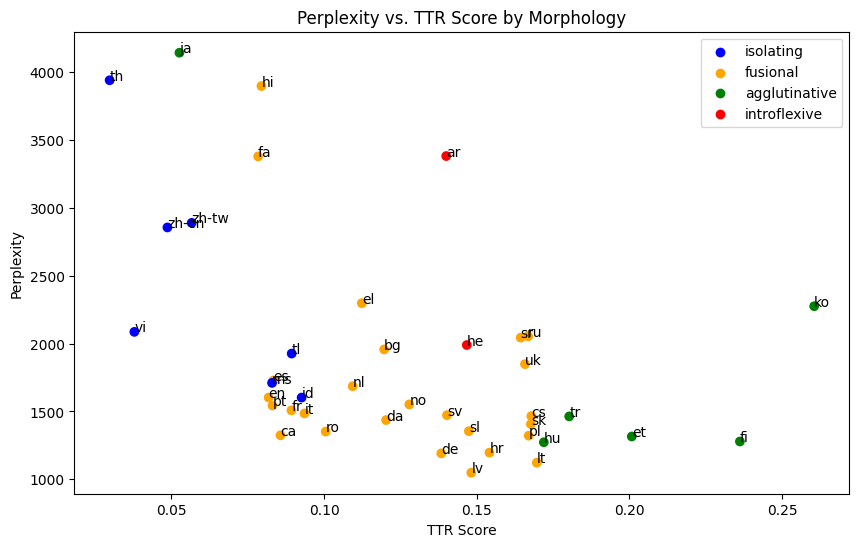

In [ ]:
plot_scatter_results(perplexity_dict_sp, ttr_values_sp, morphology_dict)